# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


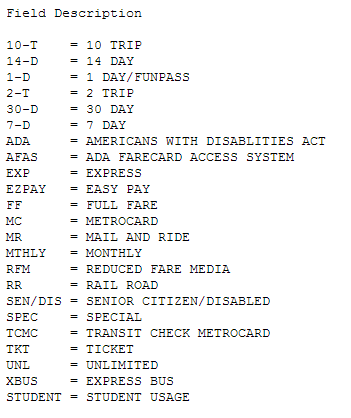

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [2]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import os
import json
import pylab as pl
from scipy import stats

import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data Reading

In [3]:
mtaRides = np.load('MTA_Fare.npy')

In [4]:
mtaRides.shape

(600, 23, 194)

In [5]:
mtaRides = mtaRides.astype(float)

In [6]:
#mtaRides[mtaRides == -1.] = np.NaN

In [7]:
dates = pd.date_range(start='05/21/2010', periods=194, freq='W-FRI')
dates

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [8]:
# aggregating weekly data into a list of 194 weeks
# each week contains all stations and card types 

weeks = []

for i in range(194):
    x = []
    for j in range(600):
        for k in range(23):
            x.append(mtaRides[j][k][i])
    i = sum(x)
    weeks.append(i)
    
weeks

[26716631.0,
 29262313.0,
 29597575.0,
 29383978.0,
 29182176.0,
 26208052.0,
 28680022.0,
 29122010.0,
 28800200.0,
 28595932.0,
 28308361.0,
 27927423.0,
 27268131.0,
 28246743.0,
 26683582.0,
 30015142.0,
 30180176.0,
 29048486.0,
 30065000.0,
 29168839.0,
 30323454.0,
 30186700.0,
 29983681.0,
 30049876.0,
 30125402.0,
 25160821.0,
 29185649.0,
 30577220.0,
 30103021.0,
 27557647.0,
 21799403.0,
 21792798.0,
 27479553.0,
 27108970.0,
 26010345.0,
 26430220.0,
 28656503.0,
 29100353.0,
 29573058.0,
 26718018.0,
 29176634.0,
 29397046.0,
 29876972.0,
 29673828.0,
 29521768.0,
 30172126.0,
 30193061.0,
 28496477.0,
 29031851.0,
 30394695.0,
 29988635.0,
 29949834.0,
 27144981.0,
 29846497.0,
 30162349.0,
 29975652.0,
 30294451.0,
 26740659.0,
 29964051.0,
 29471983.0,
 29249492.0,
 29426206.0,
 29059658.0,
 27976524.0,
 27921014.0,
 22981394.0,
 28139307.0,
 31992892.0,
 32503085.0,
 24294628.0,
 32156059.0,
 30744539.0,
 32638048.0,
 32901236.0,
 31950684.0,
 32127913.0,
 32474319.0,

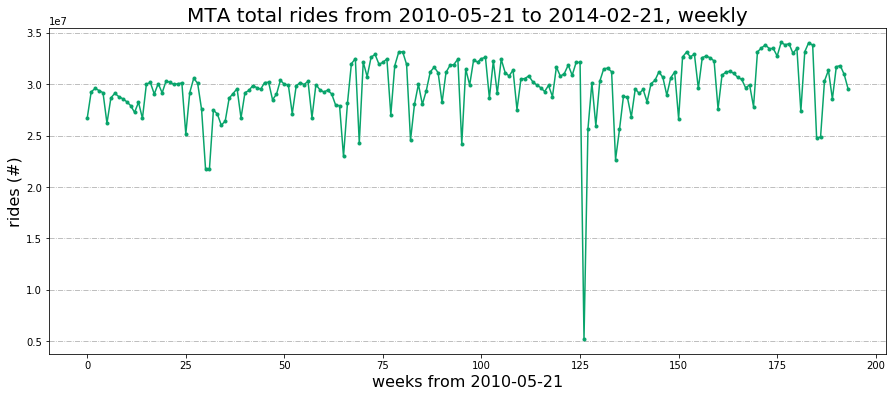

In [9]:
# ploting weekly data to detect major event

fig = pl.figure(figsize=(15,6))
ax = fig.add_subplot(111)

ax.plot(weeks,'.-', color = '#08A46B')

ax.grid(axis='y', linestyle='-.');

pl.title('MTA total rides from 2010-05-21 to 2014-02-21, weekly', fontsize=20)
pl.xlabel('weeks from 2010-05-21', fontsize=16)
pl.ylabel('rides (#)', fontsize=16)
pl.show()

### Fig.1 MTA total rides from 2010-05-21 to 2014-02-21, weekly. A major event is observed around week 125/6. 

In [10]:
print("mean of weekly mta rides: {:.2f}\nstd of weekly mta rides: {:.2f}".format(np.mean(weeks),np.std(weeks)))

mean of weekly mta rides: 29778001.61
std of weekly mta rides: 2984034.35


In [11]:
threshold = np.mean(weeks)-3*np.std(weeks)
print("threshold, set to mean - 3*std, is: {:.2f}".format(threshold))

threshold, set to mean - 3*std, is: 20825898.56


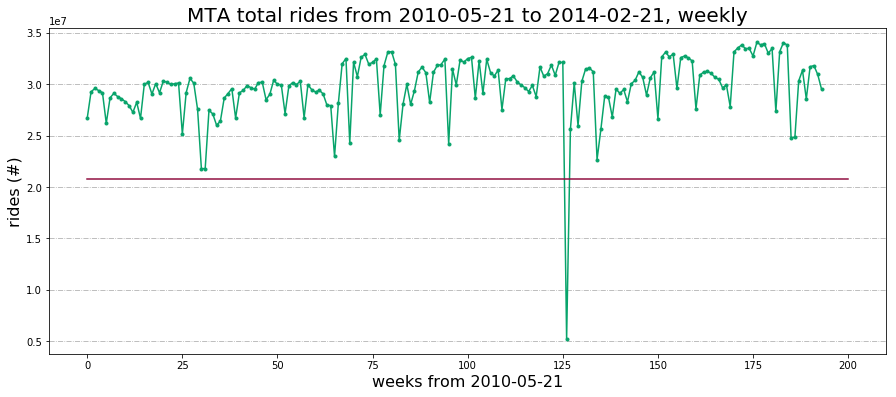

In [12]:
fig = pl.figure(figsize=(15,6))
ax = fig.add_subplot(111)

pl.plot(weeks,'.-', color = '#08A46B')
pl.plot((0,200), (threshold,threshold), color = '#900C3F')

ax.grid(axis='y', linestyle='-.');

pl.title('MTA total rides from 2010-05-21 to 2014-02-21, weekly', fontsize=20)
pl.xlabel('weeks from 2010-05-21', fontsize=16)
pl.ylabel('rides (#)', fontsize=16)
pl.show()

## Fig.2 MTA total rides from 2010-05-21 to 2014-02-21, weekly
### including minimum threshold defined as _3*std from the mean_. The major event that occured around week 125/6 is the only event in the sense of the threshold of 99.7% of the data (3 sigma). 

In [13]:
event = np.where(weeks < threshold)
event

(array([126]),)

In [14]:
dates[126]

Timestamp('2012-10-19 00:00:00', offset='W-FRI')

## The event occuring in the days after Oct19 is _Hurricane Sandy, 10.22.2012_

![sandysubway.jpeg](sandysubway.jpeg)

_____

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

## NOTE ON THE TREND DETECTION:
### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

In [15]:
mtaRides

array([[[  5.69610000e+04,   6.47030000e+04,   6.80020000e+04, ...,
           3.65270000e+04,   3.39290000e+04,   3.68240000e+04],
        [  1.73200000e+03,   2.08300000e+03,   2.10700000e+03, ...,
           1.26400000e+03,   1.17200000e+03,   1.23800000e+03],
        [  2.03000000e+02,   2.76000000e+02,   2.45000000e+02, ...,
           1.86000000e+02,   1.67000000e+02,   1.67000000e+02],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00, ...,
           1.12100000e+03,   1.37700000e+03,   7.12000000e+02]],

       [[  1.62100000e+04,   2.01790000e+04,   2.17690000e+04, ...,
          -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00],
        [  5.03000000e+02,   6.47000000e+02,   6.65000000e+0

In [16]:
# Card types as given by fbb

ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [17]:
# creating dates list of the given sampled weeks

dates = pd.date_range(start='05/21/2010', periods=194, freq='W-FRI')
dates

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

In [18]:
station = np.nansum(mtaRides, axis = 1)
station = np.nansum(station, axis =1)
station.shape

(600,)

In [19]:
ticket = np.average(mtaRides, axis = 0, weights = station)
ticket.shape

(23, 194)

### Having the data in 2D now it is reasonable to read it as pd.DataFrame:

In [20]:
dfticket = pd.DataFrame(ticket.T)
dfticket.set_index(dates, inplace=True)
dfticket.columns = ridetype

dfticket.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-21,56340.248436,2572.363736,201.274923,819.952564,337.841583,16204.896085,42572.147962,43.950814,1975.602544,2272.746850,...,874.787455,3512.544806,365.240927,156.252101,-0.001415,470.493015,46.354569,14.043241,0.939638,-1.0
2010-05-28,61784.169841,2851.236617,217.849553,875.031352,465.540071,17346.538269,47615.355867,51.948752,1629.466469,2600.703764,...,1078.233312,4037.998902,421.810680,179.029745,-0.002603,467.096610,47.839795,13.924050,1.241840,-1.0
2010-06-04,63195.150500,2864.982470,219.504557,877.788957,416.016363,17614.497092,47663.189037,53.970907,1744.086823,2794.923451,...,1074.661416,4072.654323,427.415041,180.642945,-0.001113,464.684466,47.324135,14.706028,1.206147,-1.0
2010-06-11,62281.748762,2732.035297,220.232506,864.976055,273.080658,17577.464724,47483.367567,49.011516,1766.348777,2743.685207,...,1042.222199,4012.662853,415.547553,180.095290,-0.001113,461.321249,47.613429,14.986673,1.259083,-1.0
2010-06-18,62809.015181,2654.502317,215.758480,858.933795,256.939922,17174.227134,46804.736315,45.844959,1940.025225,2566.574467,...,980.379363,3850.264024,405.643480,176.135134,0.506869,459.882158,44.617728,14.223956,1.175104,-1.0


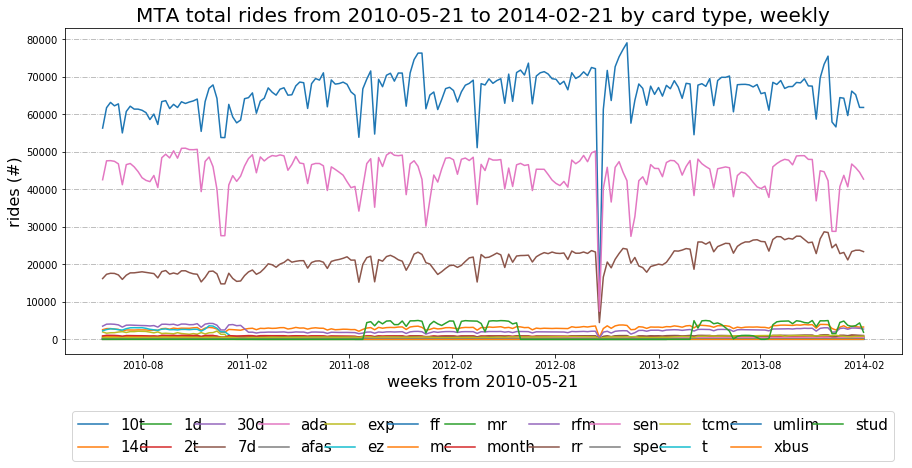

In [21]:
fig = pl.figure(figsize=(15,6))
ax = fig.add_subplot(111)

ax.plot(dfticket)

ax.grid(axis='y', linestyle='-.');
    
pl.title('MTA total rides from 2010-05-21 to 2014-02-21 by card type, weekly', fontsize=20)
pl.xlabel('weeks from 2010-05-21', fontsize=16)
pl.ylabel('rides (#)', fontsize=16)
pl.legend(ridetype,fontsize=15, loc='lower center', ncol=12, mode="expand",bbox_to_anchor=(0., -.35, 1., .102))
pl.show()

## Fig.3 MTA total rides from 2010-05-21 to 2014-02-21 by card type, weekly. It is hard to assess which card type has a stationary time series.

## Calculating rolling mean:

In [22]:
len(dfticket.columns)

23

In [23]:
ticketroll = []

for i in dfticket.columns:
    ticketroll.append(pd.rolling_mean(dfticket[i], 10))
    
ticketroll

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


[2010-05-21             NaN
 2010-05-28             NaN
 2010-06-04             NaN
 2010-06-11             NaN
 2010-06-18             NaN
 2010-06-25             NaN
 2010-07-02             NaN
 2010-07-09             NaN
 2010-07-16             NaN
 2010-07-23    60723.216649
 2010-07-30    61199.282754
 2010-08-06    61067.875730
 2010-08-13    60610.724368
 2010-08-20    60391.899942
 2010-08-27    59842.539485
 2010-09-03    60678.693760
 2010-09-10    60968.239852
 2010-09-17    60905.130587
 2010-09-24    61031.883633
 2010-10-01    61075.244896
 2010-10-08    61302.190832
 2010-10-15    61546.620124
 2010-10-22    62014.596937
 2010-10-29    62364.701907
 2010-11-05    63042.618816
 2010-11-12    62248.097125
 2010-11-19    62223.106980
 2010-11-26    62763.214982
 2010-12-03    63281.457210
 2010-12-10    63525.502362
                   ...     
 2013-07-12    67388.382426
 2013-07-19    67886.478872
 2013-07-26    67779.784201
 2013-08-02    67342.645747
 2013-08-09    66936

In [24]:
dfticketroll = (pd.DataFrame(ticketroll).T)
dfticketroll.head(11)

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-23,60723.216649,2578.529761,210.215225,837.943188,348.614091,17232.096050,45761.057960,47.974712,1917.222267,2753.620179,...,976.482018,3775.244757,393.741941,172.330433,1.015629,460.597642,46.546305,14.976411,1.241885,-1.0


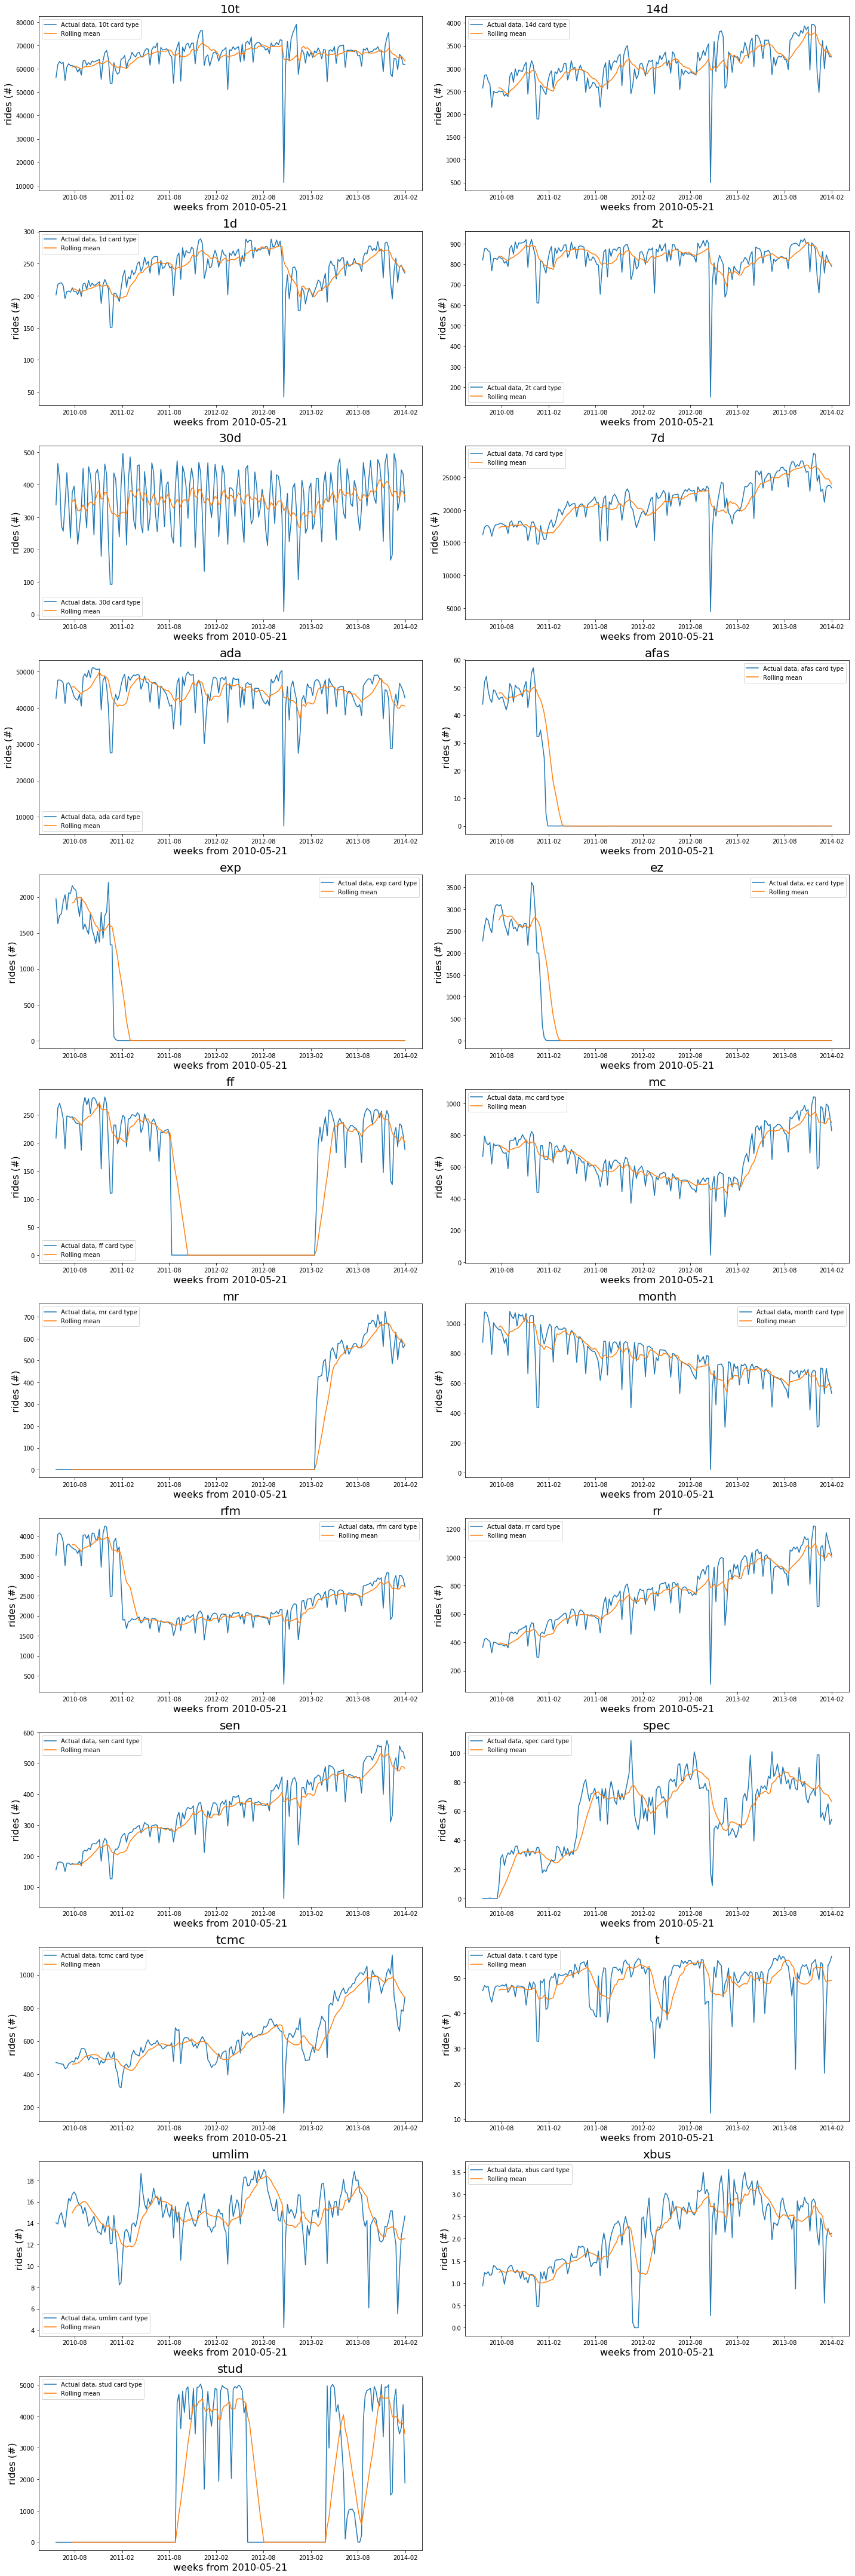

In [25]:
fig = pl.figure(figsize=(20,60))

for i in range(len(dfticket.columns)):
    ax = fig.add_subplot(12,2,i+1)
    ax.plot(dfticket.iloc[:,i], label='Actual data, {} card type'.format(dfticket.columns[i]))
    ax.plot(dfticketroll.iloc[:,i], label="Rolling mean")
    ax.set_title(dfticket.columns[i], fontsize=20)
    ax.set_xlabel('weeks from 2010-05-21', fontsize=16)
    ax.set_ylabel('rides (#)', fontsize=16)
    ax.legend(fontsize=10)
    
pl.tight_layout()

## Fig.4 MTA total rides by card types, from 2010-05-21 to 2014-02-21,  weekly. 
Some trends are observed, as well as card types that apparently were not in use during parts of the period sampled. 

## AD-Fuller test
Null hypothsis: there is a unit root (meaning the series is _not stationary_)

To reject the Null hypothesis the p-value should be below the critical value of 5%.

In [26]:
stationary = []
notstationary = []

for i in range(len(dfticket.columns)):
    stationarytest = sm.tsa.adfuller(dfticket.iloc[:,i])
    if (stationarytest[0] > stationarytest[4]['5%']):
        notstationary.append(dfticket.columns[i])
    else:
        stationary.append(dfticket.columns[i])
        
print("AD Fuller test results for MTA's 23 card types time series:\n")
print("Stationary Card Type time series:\n",stationary)
print("\nNon-Stationary Card Type time series:\n",notstationary)

AD Fuller test results for MTA's 23 card types time series:

Stationary Card Type time series:
 ['10t', '2t', '30d', 'ada', 'exp', 't', 'umlim']

Non-Stationary Card Type time series:
 ['14d', '1d', '7d', 'afas', 'ez', 'ff', 'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 'xbus', 'stud']


### Calculating what card type is the most increased trend and the mosr decresed trend (claculating ratio of last 10 weeks mean over first 10 weeks mean):

In [27]:
first10mean = np.mean(dfticket[:10])
last10mean = np.mean(dfticket[185:])

In [28]:
meanratio = last10mean/first10mean
meanratio.sort_values()

stud     -3280.796545
ez           0.000002
exp          0.000009
afas         0.000254
month        0.569590
rfm          0.710187
ff           0.808549
umlim        0.829660
ada          0.880526
2t           0.937685
10t          1.021612
30d          1.025609
t            1.045867
1d           1.111511
mc           1.181917
14d          1.232183
7d           1.362477
xbus         1.582929
tcmc         1.827825
rr           2.487069
sen          2.759979
spec        65.185988
mr       22502.624803
dtype: float64

## Results:
It seems like the most increasing card type is _Male and Ride_ ('mr') card type, though looking at its individual plot in Fig.4 we understand it was started to be in use only arount February 2013; After it, 'spec' doesn't seem to have a steady trend. Thus I would say that **the most increasing card type is _Senior_** ('sen').  

Also, It seems that the most decreasing Card type is _Student_ ('stud') card type, though we see from Fig.4 that there is missing data or it had been out of use for some weeks. 'ez', 'exp' and 'afas' were probably got out of use at some point. Thus **the most decreasing Card type is _Monthly_** ('month').

____

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [29]:
stations = np.nansum(mtaRides, axis = 1)
stations.shape

(600, 194)

## Fig5. Fourier transformation of the MTA rides. Data shows the power spectrum at the frequency of 52 weeks. 

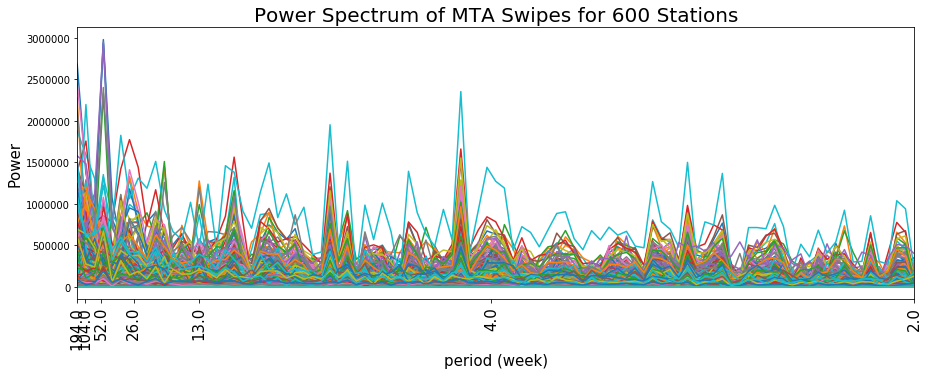

In [30]:
# this is a "power spectrum": the plot of the absolute value of the fourier transform. 

N = len(dates)
allperiods = [1/194.0, 1/104.0, 1/52.0, 1/26.0, 1/13.0, 1/4.0, 1/2.0]

fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(len(stations)):
    f = np.abs(np.fft.rfft(stations[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
    
ax.set_xlim([1/194.0, 1/2.0])
ax.set_xticks(allperiods)
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], fontsize=15, rotation=90)
pl.xlabel("period (week)", fontsize=15)
pl.ylabel("Power", fontsize=15)
pl.title("Power Spectrum of MTA Swipes for 600 Stations", fontsize=20)
pl.show();

## Fig5. Power of MTA rides for 600 stations. Data shows the power spectrum at the frequency of 2, 4, 13, 26, 52, 104 and 194 weeks. 
it ise hard to view clearly the periodicity of the individual stations due to their large number. However, we can see certain spikes in most stations at around the 52 week and around 5/6 weeks

In [31]:
# Finding the stations with the most prominent annual periodicity of rides
# Observing Fig.5 I will define my threshold for this at 2400000 rides

prominent = []

for i in range(len(stations)):
    f = np.abs(np.fft.rfft(stations[i]))
    if (f[4] > 2400000):
        prominent.append(i)

prominent

[0, 150, 194, 327]

## Results: Total MTA Stations with the most prominent annual periodicity are stations **#0, #150, #194, #327**

___

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

In [32]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T

In [33]:
tots.shape

(13800, 194)

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

In [34]:
tots = tots[tots.std(1)>0]
tots.shape

(9317, 194)

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

In [35]:
KMeans(n_clusters=10)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft()  

```
np.fft.rfft(mydata) 
```  

      will return the *real* part of the fourier transform (the fourier transform is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math; all you need to know is that you need the real part). But what you want is its absolute value: np.abs(). 
      To plot the fourier transform you may want the x-axis to be in frequency. To get the x-axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

*  after you operate on the array to collapse an axis, always check the dimensionality to assure you have indeed collapsed the right axis! see cell below

```
import numpy as np
data = np.random.rand(100,10)

print(data.shape)
Out[12]: (100, 10)

print(data.mean())
Out[13]:  0.4902457782

print(data.mean(axis=0).shape, data.mean(axis=1).shape)
Out[14]: (10,) (100,)

```

In [36]:
#after reading the datacube you should see:
mtaRides.shape


(600, 23, 194)

ride types list

In [37]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [38]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

In [ ]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

In [ ]:
# this is a "power spectrum": the plot of the absolute value of the fourier transform. 
# I changed the xtick labels from frequecy (1/week) to period (in weeks)
# to facilitate the visual identification of the 1-year period peak
# (notice however that np.fft.rfftfreq(N, d)  returns frequency, the inverse of the period: frequency = 1/period. 
# All I did was changing the tick labels): 

...
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90)

In [ ]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space